In [27]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os

In [28]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Flatten, ZeroPadding2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam

In [29]:
# Load every preprocessed data
dataset = np.load("utils//preprocessed.npz")
x = dataset['x']

data = tf.convert_to_tensor(x, tf.float16)
del x

In [50]:
def generator(noise_shape):
    model = Sequential(name='generator')
    
    momentum = 0.9
    epsilon = 10**5

    # Random Noise to 4x4x256
    model.add(Dense(4*4*256, input_shape=[noise_shape]))
    model.add(BatchNormalization())
    model.add(ReLU())

    # Reshape reverse into 512x4x4
    model.add(Reshape([4, 4, 256]))
    model.add(Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding="same", kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02)))
    model.add(BatchNormalization())
    model.add(ReLU())
    
    model.add(Conv2DTranspose(64, kernel_size=(4, 4), strides=(2, 2), padding="same", kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02)))
    model.add(BatchNormalization())
    model.add(ReLU())
    
    model.add(Conv2DTranspose(32, kernel_size=(4, 4), strides=(2, 2), padding="same", kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02)))
    model.add(BatchNormalization())
    model.add(ReLU())
    
    # Output with tanh
    model.add(Conv2DTranspose(3, kernel_size=(2, 2), strides=(2, 2), padding="same", activation='tanh'))
    
    return model

generator = generator(100)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 4096)              413696    
                                                                 
 batch_normalization_21 (Bat  (None, 4096)             16384     
 chNormalization)                                                
                                                                 
 re_lu_12 (ReLU)             (None, 4096)              0         
                                                                 
 reshape_3 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 8, 8, 128)        524416    
 Transpose)                                                      
                                                                 
 batch_normalization_22 (Bat  (None, 8, 8, 128)        51

In [51]:
def discriminator():
    model = Sequential(name='discriminator')

    model.add(Conv2D(32, (3, 3), strides=(2, 2), padding='same', input_shape=[64, 64, 3]))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    #model.add(BatchNormalization())
    
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    
    model.add(Dense(1))
    
    return model

discriminator = discriminator()
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 32, 32, 32)        0         
                                                                 
 dropout_12 (Dropout)        (None, 32, 32, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_25 (Bat  (None, 16, 16, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                     

In [52]:
#discriminator.trainable = False
gan = Sequential([generator, discriminator])

gan.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator (Sequential)      (None, 64, 64, 3)         1119715   
                                                                 
 discriminator (Sequential)  (None, 1)                 406593    
                                                                 
Total params: 1,526,308
Trainable params: 1,516,772
Non-trainable params: 9,536
_________________________________________________________________


In [53]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [54]:
# define loss
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real,fake):
    real_loss = loss(tf.ones_like(real), real)
    fake_loss = loss(tf.zeros_like(fake), fake)
    return tf.add(real_loss, fake_loss)

def generator_loss(fake):
    gen_loss = loss(tf.ones_like(fake),fake)
    return gen_loss

In [55]:
EPOCHS = 50
BATCH_SIZE = 64

In [56]:
# Use tf.data.Dataset for batch processing
dataset = tf.data.Dataset.from_tensor_slices(data).shuffle(60000).batch(BATCH_SIZE)

In [57]:
@tf.function
def train_step(images):
    noise = tf.random.normal([256,100])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [58]:
def train(dataset, epochs):
    gen_loss=0
    dis_loss=0
    gen_plot = []
    dis_plot = []

    with tf.device('/gpu:0'):
        for epoch in range(epochs):
            print(f'{epoch+1} of {epochs}',end = ' ')
            print(f'generator loss is {gen_loss} and discriminator loss is {dis_loss}')

            for image_batch in dataset: 
                gen_loss, dis_loss = train_step(image_batch)
        
            gen_plot.append(gen_loss)
            dis_plot.append(dis_loss)
    
    x = [X for X in range(epochs)]
    
    plt.plot(x, gen_plot)
    plt.plot(x, dis_plot)
    plt.title('epoch vs loss')
    plt.legend(['gen_loss','dis_loss'])
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.savefig("2. result/graph_result6.jpg")
    plt.show()

1 of 50 generator loss is 0 and discriminator loss is 0
2 of 50 generator loss is 2.2765538692474365 and discriminator loss is 1.0399318933486938
3 of 50 generator loss is 2.227707862854004 and discriminator loss is 0.5170162916183472
4 of 50 generator loss is 2.211470603942871 and discriminator loss is 0.42912930250167847
5 of 50 generator loss is 1.7138053178787231 and discriminator loss is 0.918561577796936
6 of 50 generator loss is 2.2931387424468994 and discriminator loss is 0.8940443992614746
7 of 50 generator loss is 2.2278900146484375 and discriminator loss is 0.4143928587436676
8 of 50 generator loss is 2.3089849948883057 and discriminator loss is 0.6285194158554077
9 of 50 generator loss is 2.1871731281280518 and discriminator loss is 0.6798793077468872
10 of 50 generator loss is 2.593580961227417 and discriminator loss is 0.5517565608024597
11 of 50 generator loss is 2.093083143234253 and discriminator loss is 0.6547526121139526
12 of 50 generator loss is 2.0005457401275635 

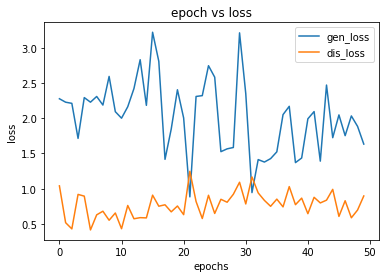

In [59]:
train(dataset, EPOCHS)

In [60]:
noice = np.random.randn(32,100)
pred = generator.predict(noice)

1/1 [==============================] - 0s 125ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

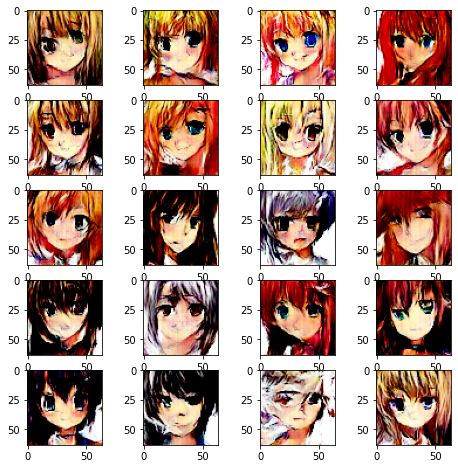

In [61]:
w=10
h=10
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(pred[i],cmap='gray')
plt.savefig("2. result/generated_result6.jpg")
plt.show()

In [10]:
generator.save("utils//generator.h5")
discriminator.save("utils//discriminator.h5")
gan.save("utils//gan.h5")